In [11]:
import numpy as np
from glob import glob

# !unzip -q dataset/dog_dataset.zip

dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

dog_files_short = dog_files[:100]

There are 8354 total dog images.


In [4]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("cuda available? {0}".format(use_cuda))

cuda available? False


In [7]:
# define VGG16 model
from torchvision.models import VGG16_Weights


VGG16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [8]:
from PIL import Image
import torchvision.transforms as transforms

def load_image(img_path):    
    image = Image.open(img_path)

    # resize to (244, 244) because VGG16 accept this shape
    in_transform = transforms.Compose(
                        [transforms.Resize(size=(244, 244)),
                        transforms.ToTensor()])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image).unsqueeze(0)
    return image

In [13]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    img = load_image(img_path)
    # print(img)
    # if not(img.shape == [1, 4, 244, 244]):
    #     return 0
    if use_cuda:
        img = img.cuda()
    ret = VGG16(img)
    return torch.max(ret,1)[1].item() # predicted class index

In [22]:
# predict dog using ImageNet class
VGG16_predict(dog_files_short[0])

552

In [23]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 20
num_workers = 0

data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [24]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [25]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     normalize]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     normalize])
                  }

In [26]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [27]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

num_classes = 133 # total classes of dog breeds

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7 * 7 * 128, 512)
        self.fc2 = nn.Linear(512, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# instantiate the CNN
model_scratch = Net()
print(model_scratch)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [27]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

In [28]:
def train_self(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [29]:
# train the model
model_scratch = train_self(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'saved_models/model_scratch.pt')

Epoch 1, Batch 1 loss: 4.891568
Epoch 1, Batch 101 loss: 4.888866
Epoch 1, Batch 201 loss: 4.880668
Epoch 1, Batch 301 loss: 4.873292
Epoch: 1 	Training Loss: 4.868258 	Validation Loss: 4.786849
Validation loss decreased (inf --> 4.786849).  Saving model ...
Epoch 2, Batch 1 loss: 4.779703
Epoch 2, Batch 101 loss: 4.790125
Epoch 2, Batch 201 loss: 4.772353
Epoch 2, Batch 301 loss: 4.746068
Epoch: 2 	Training Loss: 4.739027 	Validation Loss: 4.563685
Validation loss decreased (4.786849 --> 4.563685).  Saving model ...
Epoch 3, Batch 1 loss: 4.565310
Epoch 3, Batch 101 loss: 4.643067
Epoch 3, Batch 201 loss: 4.625503
Epoch 3, Batch 301 loss: 4.622723
Epoch: 3 	Training Loss: 4.618967 	Validation Loss: 4.446266
Validation loss decreased (4.563685 --> 4.446266).  Saving model ...
Epoch 4, Batch 1 loss: 4.659532
Epoch 4, Batch 101 loss: 4.583733
Epoch 4, Batch 201 loss: 4.571528
Epoch 4, Batch 301 loss: 4.553342
Epoch: 4 	Training Loss: 4.552071 	Validation Loss: 4.409920
Validation loss de

In [30]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('saved_models/model_scratch.pt'))

<All keys matched successfully>

In [31]:
def test_model(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test_model(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.079507


Test Accuracy:  9% (78/839)


In [32]:
## Specify data loaders
loaders_transfer = loaders_scratch.copy()

In [1]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

In [2]:
for param in model_transfer.parameters():
    param.requires_grad = False

In [3]:
model_transfer.fc = nn.Linear(2048, 133, bias=True)

In [4]:
fc_parameters = model_transfer.fc.parameters()

In [5]:
for param in fc_parameters:
    param.requires_grad = True

In [6]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

NameError: name 'optim' is not defined

In [32]:
# train the model
# train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [33]:
train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'saved_models/model_transfer.pt')

NameError: name 'loaders_transfer' is not defined

In [31]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('saved_models/model_transfer.pt'))

NameError: name 'model_transfer' is not defined

In [44]:
test_model(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.810090


Test Accuracy: 73% (616/839)


In [45]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

In [46]:
loaders_transfer['train'].dataset.classes[:10]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog']

In [47]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [48]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     normalize])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image).unsqueeze(0)
    return image

In [29]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [30]:
count = 0
total = 0
for img_file in os.listdir('./small_test'):
    img_path = os.path.join('./small_test', img_file)
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t prediction breed: {1}".format(img_path, prediction))
    prediction = prediction.replace(" " ,"_")
    
    if(prediction.lower() in img_path.lower()):
        count += 1
    total += 1

print("Accuracy: {:.6f}% ~ {1}/{2}".format((count/total)*100, count, total))


NameError: name 'model_transfer' is not defined

In [51]:
def run_app(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("HELLO!!!!\nIt looks like a {0}.".format(prediction))  

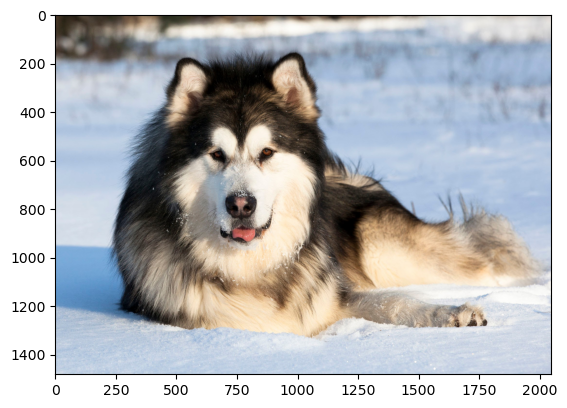

HELLO!!!!
It looks like a Alaskan malamute.


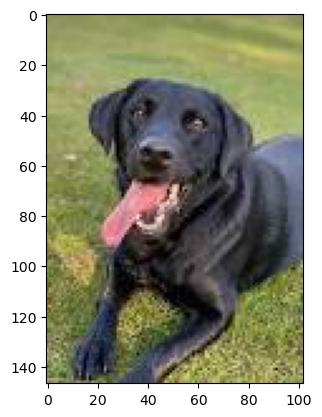

HELLO!!!!
It looks like a Curly-coated retriever.


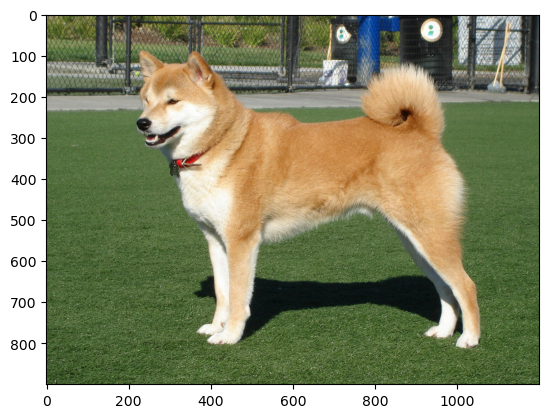

HELLO!!!!
It looks like a Akita.


In [52]:
for img_file in os.listdir('./dogs'):
    img_path = os.path.join('./dogs', img_file)
    run_app(img_path)

In [60]:
my_human_files = ['./my_images/human_1.jpg', './my_images/human_2.jpg', './my_images/human_3.jpg', './my_images/human_4.jpg' ]
my_dog_files = ['./my_images/dog_1.jpg', './my_images/dog_2.jpg', './my_images/dog_3.jpg']

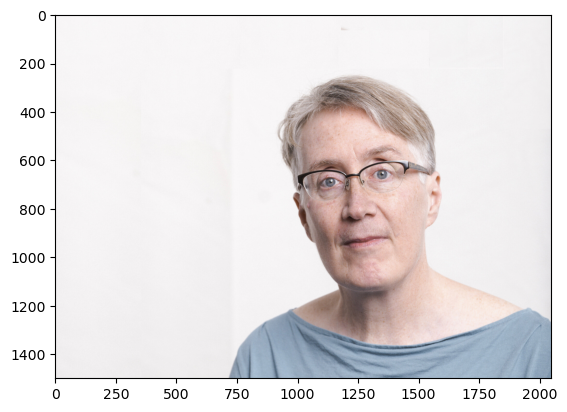

HELLO!!!!
It looks like a Italian greyhound.


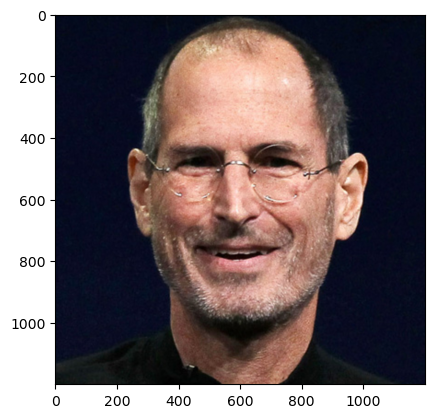

HELLO!!!!
It looks like a Dogue de bordeaux.


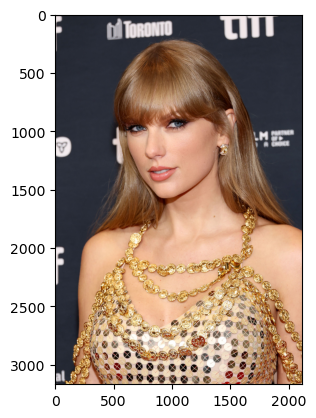

HELLO!!!!
It looks like a Cocker spaniel.


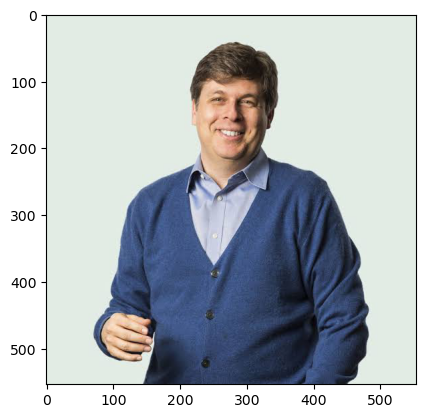

HELLO!!!!
It looks like a Brussels griffon.


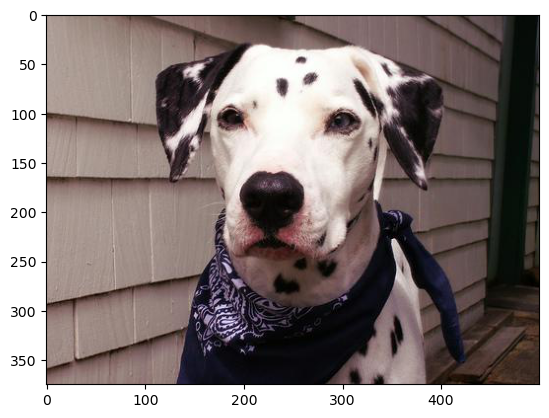

HELLO!!!!
It looks like a Dalmatian.


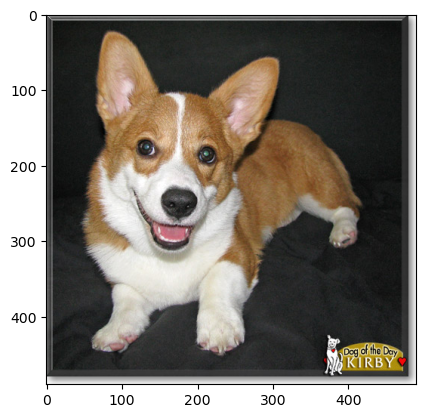

HELLO!!!!
It looks like a Pembroke welsh corgi.


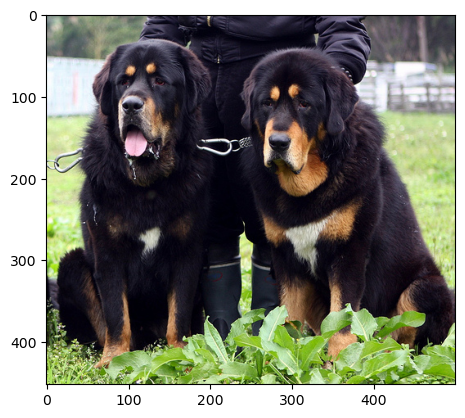

HELLO!!!!
It looks like a Tibetan mastiff.


In [61]:
for file in np.hstack((my_human_files, my_dog_files)):
    run_app(file)